In [1]:
%load_ext autoreload
%autoreload 2

## Get dataset to train

In [2]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

Fs = 100  # Sampling frequency

# Path to the folder containing the CSV files
folder_path = "TFO Data\IMU"

# Get the list of CSV files in the folder
file_list = glob.glob(folder_path + "\*.csv")
file_path = file_list[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(file_path)
df = df[df.columns[2:-1]]  # Remove the time, index, and temperature columns
    
# Show the head of the dataframe
title = file_path.split("\\")[-1]
print(title)
print(df.shape)
df.head()

P19V1_20.csv
(110172, 12)


,ax1,ay1,az1,gx1,gy1,gz1,ax2,ay2,az2,gx2,gy2,gz2
0,0.042,-0.434,-0.837,-1.717,1.022,0.816,0.133,0.005,-1.031,-3.113,1.747,-1.862
1,0.043,-0.437,-0.842,-1.846,0.916,0.496,0.135,0.005,-1.027,-2.853,1.717,-1.869
2,0.044,-0.434,-0.839,-1.717,1.289,0.687,0.133,0.004,-1.028,-2.350,1.785,-1.801
3,0.040,-0.438,-0.836,-1.724,1.106,0.732,0.135,0.005,-1.026,-2.396,1.831,-1.640
4,0.044,-0.438,-0.838,-1.671,1.022,0.534,0.135,0.003,-1.023,-2.335,1.923,-1.404


### Normalize data in dataframe

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler() # Can't use this with BCELoss
#scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

,ax1,ay1,az1,gx1,gy1,gz1,ax2,ay2,az2,gx2,gy2,gz2
0,0.230236,1.627046,-0.611045,-0.196632,0.388310,0.238405,-1.498117,0.410524,-1.664147,-1.221645,-0.157399,-0.492049
1,0.292071,1.343254,-1.294657,-0.399282,0.219007,-0.307369,-1.332153,0.410524,-0.866719,-0.854196,-0.208270,-0.506191
2,0.353905,1.627046,-0.884490,-0.196632,0.814763,0.018390,-1.498117,0.348344,-1.066076,-0.143323,-0.092962,-0.368807
3,0.106566,1.248657,-0.474323,-0.207628,0.522475,0.095139,-1.332153,0.410524,-0.667362,-0.208334,-0.014959,-0.043529
4,0.353905,1.248657,-0.747767,-0.124369,0.388310,-0.242559,-1.332153,0.286163,-0.069291,-0.122124,0.141045,0.433277


In [4]:
x = df['ax1']
y = df['ay1']
print(x.shape)
print(y.shape)

(110172,)
(110172,)


## Create model and dataloaders

In [5]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
# data = window_data(x, 100)
data_x = window_data(x, 100)
data_y = window_data(y, 100)
# print(f"Data shape: {data.shape}")
print(f"Data shape: {data_x.shape}")
print(f"Data shape: {data_y.shape}")

# Create a DataLoader object
#dataloader = DataLoaderGenerator(data, batch_size=32)
dataloader = DataLoaderGenerator([data_x, data_y], batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()
print(f"Number of batches: {len(train_loader)}")

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)#, device='cpu')


Data shape: (110073, 100)
Data shape: (110073, 100)
Number of batches: 6879


In [6]:
from torchsummary import summary
if torch.cuda.is_available():
    vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [7]:
train_save = True
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/example_vae.pth")
else:
    # Load the model
    vae.load_model("Weights/example_vae.pth")
    vae.eval()

Epoch 1/10, Loss: 243.64439392089844
Epoch 2/10, Loss: 251.72406005859375
Epoch 3/10, Loss: 235.87673950195312
Epoch 4/10, Loss: 272.1493225097656
Epoch 5/10, Loss: 224.5716552734375
Epoch 6/10, Loss: 193.748291015625
Epoch 7/10, Loss: 198.85781860351562
Epoch 8/10, Loss: 217.3817138671875
Epoch 9/10, Loss: 244.42062377929688
Epoch 10/10, Loss: 195.04769897460938


### Loss Analysis

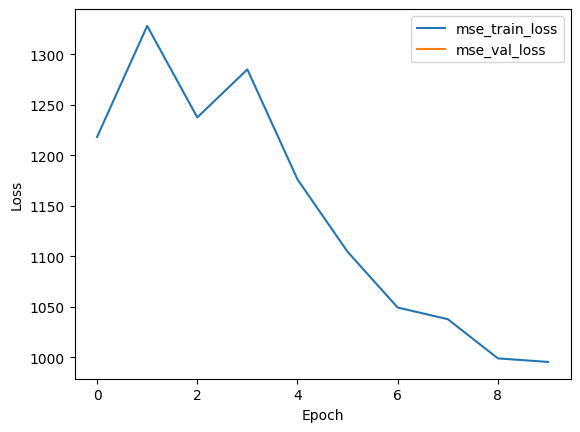

In [8]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [9]:
encoded_training_data = vae.encode_data(train_loader)

In [10]:
print(encoded_training_data.shape)

(220128, 6)


In [11]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [12]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([220128, 1, 6])

In [13]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
if torch.cuda.is_available():
    lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
│    └─Linear: 2-4                       [1, 6]                    42
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22

## Train LSTM

In [14]:
train_save = True
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/example_lstm.pth")
else:
    # Load the model
    lstm.load_model("Weights/example_lstm.pth")
    lstm.eval()

Epoch 1/10, Loss: 11.965702056884766
Epoch 2/10, Loss: 6.65172815322876
Epoch 3/10, Loss: 3.8627493381500244
Epoch 4/10, Loss: 2.3587100505828857
Epoch 5/10, Loss: 1.2171809673309326
Epoch 6/10, Loss: 0.4221632480621338
Epoch 7/10, Loss: 0.22341544926166534
Epoch 8/10, Loss: 0.13190145790576935
Epoch 9/10, Loss: 0.08600965887308121
Epoch 10/10, Loss: 0.06986919045448303


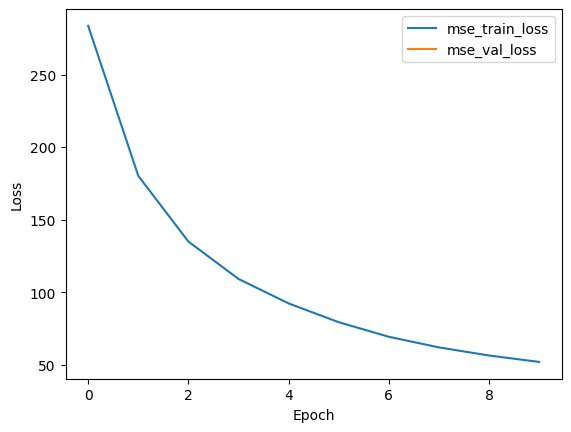

In [15]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [16]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)

In [17]:
import numpy as np


test_data = x
anomalies = np.random.randint(0, 10, len(test_data))    # Random anomalies to test with
anomalies = anomalies > 8
print(f"Anomalies: {anomalies}")    

Anomalies: [False False False ...  True False False]


In [18]:
import numpy as np

if isinstance(anomalies, np.ndarray) and anomalies.dtype == bool:
    print("anomalies is a numpy array of booleans")
else:
    print("anomalies is not a numpy array of booleans")

anomalies is a numpy array of booleans


Threshold: 0.1, Precision: 0.09871681716341911, Recall: 0.13127482845792704, F1 Score: 0.11269133888781244
	Augmented Precision: 0.45484785019095725, Augmented Recall: 1.0, Augmented F1 Score: 0.6252857989668896
Threshold: 0.125, Precision: 0.09868421052631579, Recall: 0.12865655471289275, F1 Score: 0.11169462298165858
	Augmented Precision: 0.4597567556348844, Augmented Recall: 1.0, Augmented F1 Score: 0.6299087212443484
Threshold: 0.15000000000000002, Precision: 0.09904424778761062, Recall: 0.12630913687251716, F1 Score: 0.1110273401849133
	Augmented Precision: 0.4653390471388959, Augmented Recall: 1.0, Augmented F1 Score: 0.6351281610184071
Threshold: 0.17500000000000002, Precision: 0.09919028340080972, Recall: 0.12387143373058866, F1 Score: 0.11016540870403083
	Augmented Precision: 0.4705982324949014, Augmented Recall: 1.0, Augmented F1 Score: 0.6400092453484341
Threshold: 0.2, Precision: 0.09918639053254438, Recall: 0.12107258938244854, F1 Score: 0.10904212067002764
	Augmented Prec

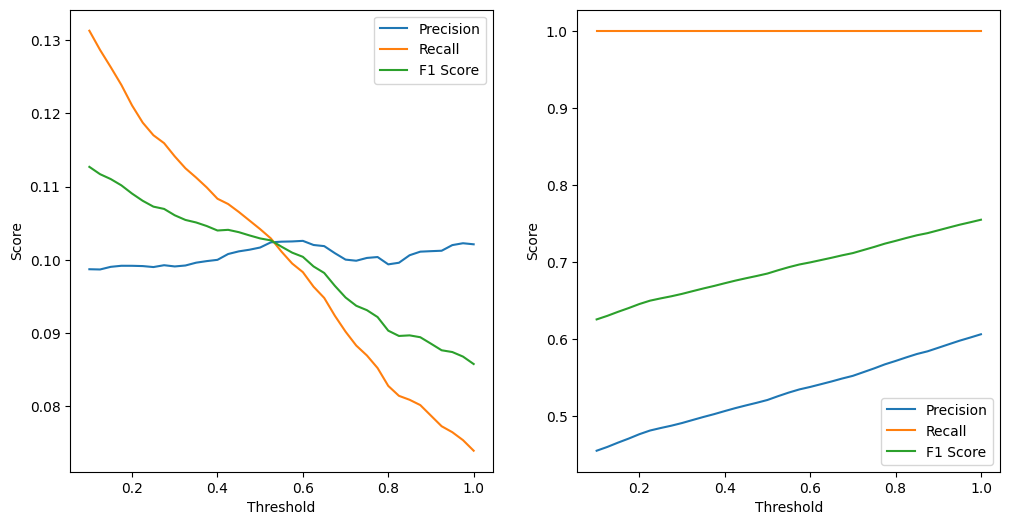

Best threshold: 0.1
Best precision: 0.09871681716341911
Best recall: 0.13127482845792704
Best F1: 0.11269133888781244
Best threshold (augmented): 1.0
Best precision (augmented): 0.6060075504732724
Best recall (augmented): 1.0
Best F1 (augmented): 0.7546758423329814


In [19]:
best_threshold, best_precision, best_recall, best_f1, best_threshold_aug, best_precision_aug, best_recall_aug, best_f1_aug = \
    vae_lstm.evaluate(test_data, anomalies, plot=True)

print(f"Best threshold: {best_threshold}")
print(f"Best precision: {best_precision}")
print(f"Best recall: {best_recall}")
print(f"Best F1: {best_f1}")
print(f"Best threshold (augmented): {best_threshold_aug}")
print(f"Best precision (augmented): {best_precision_aug}")
print(f"Best recall (augmented): {best_recall_aug}")
print(f"Best F1 (augmented): {best_f1_aug}")

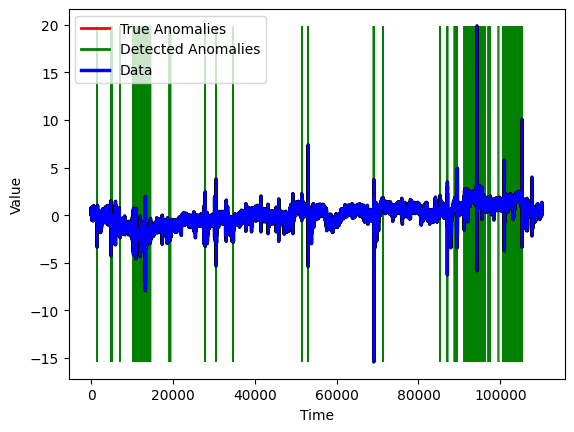

In [20]:
vae_lstm.plot_anomaly(test_data, best_threshold, None)

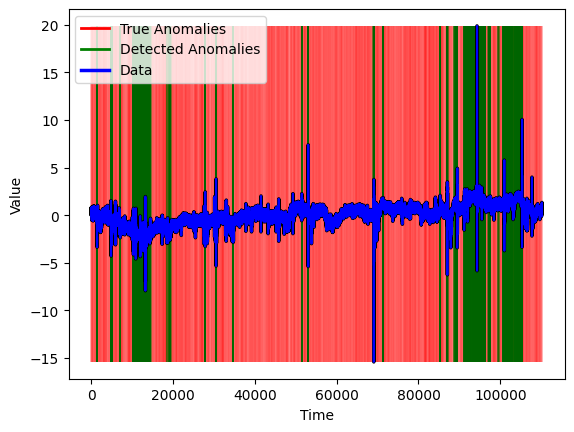

In [21]:
vae_lstm.plot_anomaly(test_data, best_threshold, anomalies)